In [1]:
import numpy as np
from qiskit.visualization import plot_histogram
import interferometer as itf
from Aquinas.numeric_truncated_unitaries import *
from Aquinas.direct_decomposition import *
from Aquinas.boson_sampling_probabilities import *
from Aquinas.simulation import *
from random import random
from qiskit.quantum_info import Operator

In [2]:
def zero_close_elements(matrix, threshold=1e-10):
    """
    Sets elements in the complex matrix to zero if their magnitude is close to zero.
    
    Parameters:
    matrix (np.ndarray): A 2D numpy array with complex numbers.
    threshold (float): A small threshold value to determine what is considered close to zero.
    
    Returns:
    np.ndarray: A matrix with elements close to zero set to exactly zero.
    """
    real_close_to_zero = np.abs(matrix.real) < threshold
    imag_close_to_zero = np.abs(matrix.imag) < threshold
    
    matrix.real[real_close_to_zero] = 0
    matrix.imag[imag_close_to_zero] = 0
    
    return matrix

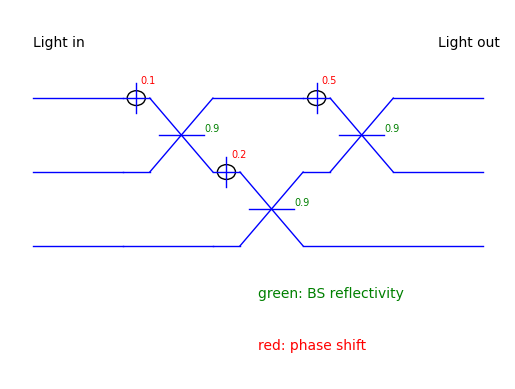

In [3]:
I = itf.Interferometer()

theta_1 = 0.1
phi_1 = 0.1

theta_2 = 0.3
phi_2 = 0.2

theta_3 = 0.1
phi_3 = 0.5

BS3 = itf.Beamsplitter(1, 2, theta=theta_3, phi=phi_3)
BS2 = itf.Beamsplitter(2, 3, theta=theta_2, phi=phi_2)
BS1 = itf.Beamsplitter(1, 2, theta=theta_1, phi=phi_1)

I.add_BS(BS1)
I.add_BS(BS2)
I.add_BS(BS3)
I.draw()

In [4]:
U = I.calculate_transformation()
print(U)

[[ 0.80801344+0.55620103j -0.18018076-0.0664769j   0.02950279+0.j        ]
 [ 0.17264399+0.08413286j  0.91821499+0.18312612j -0.29404384+0.j        ]
 [ 0.02818509+0.00871867j  0.28818254+0.05841749j  0.95533649+0.j        ]]


In [33]:
num_photons = 3
# U_trunc = numeric_truncated_unitary(U, num_photons) # Three photon circuit

In [34]:
qc = direct_decomposition(U, num_photons)
U_circ = zero_close_elements(Operator(qc).data)

In [7]:
state001 = np.array([0,1,0,0,0,0,0,0], complex)
state010 = np.array([0,0,1,0,0,0,0,0], complex)
state100 = np.array([0,0,0,0,1,0,0,0], complex)

In [8]:
statevector_from_config([1,0,0])

array([[0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [13]:
# Little endian is required here
state = statevector_from_config([1,1,1], little_endian=True)
# Expected state:
#   big endian: 01 01 01
#   little endian: 10 10 10
# This is probably a bad example since this bitstring is just flipped.
# That's not necessarily true in general.
res = (np.transpose(state) @ U_trunc @ state)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([1,1,1],[1,1,1], U))

0.579817942343877
0.5798179423438782


In [31]:
# Why does little_endian need to be false here?
state = statevector_from_config([3,0,0], little_endian=True)
# Expected state:
#   big endian: 00 00 11
#   little endian: 11 00 00
#   Could it be that it's just the blocks that need to be flipped and not the entire state?
#   That seems plausible...
res = (np.transpose(state) @ U_circ @ state)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([3,0,0],[3,0,0], U))

0.890958338541717
0.8909583385417211


In [15]:
# DEBUG FUNCTION
def statevector_from_string(binrep, little_endian = True, num_photons=None):
    if little_endian == True:
        binrep = binrep[::-1]
    
    num_qubits = len(binrep) # number of qubits in circuit
    statevector = np.zeros((2 ** num_qubits, 1), dtype=complex)
    nonzero_index = int(binrep, 2)
    statevector[nonzero_index] = 1.

    return statevector

In [21]:
# Test: flip blocks
# dist = [2, 1, 0]
# Expected state:
#   big endian: 10 01 00
#   little endian: 00 10 01 ## This is apparently correct. Another coincidence?
#   Block flipping: 01 10 00
#   Block flipping little endian: 00 01 10
flipped_state = statevector_from_string("100100", little_endian=True)
res = (np.transpose(flipped_state) @ U_circ @ flipped_state)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([2,1,0],[2,1,0], U))

0.6865576771772024
0.6865576771772038


In [37]:
flipped_state = statevector_from_config([2,1,0])
res = (np.transpose(flipped_state) @ U_circ @ flipped_state)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([2,1,0],[2,1,0], U))

0.6865576771772024
0.6865576771772038


In [40]:
ket = statevector_from_config([2,1,0])
bra = statevector_from_config([1,1,1])
res = (np.transpose(bra) @ U_circ @ ket)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([2,1,0],[1,1,1], U))

0.013182569531783414
0.01318256953178336


In [27]:
# Test 2: flip blocks
# dist = [3,0,1]
# Expected state:
#   big endian: 011 000 001
#   little endian: 100 000 110 # Another win for little endian...
#   Block flipping: 110 000 100
#   Block flipping little endian: 001 000 011

flipped_state = statevector_from_string("011000001", little_endian=True)
# res = (np.transpose(flipped_state) @ U_circ @ flipped_state)[0,0]
# print(np.absolute(res) ** 2)
# print(output_probability([3,0,1],[3,0,1], U))
# circuit_prob = 0.817480618336804
# expected_prob = 0.8174806183368121

0.817480618336804
0.8174806183368121


In [35]:
# Test: flip blocks
# dist = [2, 1, 0]
# Expected state:
#   big endian: 10 01 00
#   little endian: 00 10 01 ## This is apparently correct. Another coincidence?
#   Block flipping: 01 10 00
#   Block flipping little endian: 00 01 10
state = statevector_from_string("100100", num_photons = little_endian=True)
res = (np.transpose(flipped_state) @ U_circ @ flipped_state)[0,0]
print(np.absolute(res) ** 2)
print(output_probability([2,1,0],[2,1,0], U))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 512)

In [372]:
# Hacky way to try and figure out what statevector should actually be
state = statevector_from_config([0,1,1], little_endian=True)

for idx in range(64):
    state = np.zeros((64,1), complex)
    state[idx] = 1.0
    res = (np.transpose(state) @ U_circ @ state)[0,0]
    if (np.isclose(0.6528936318323931, np.absolute(res) ** 2)):
        print(idx)
        print(np.absolute(res) ** 2)


40
0.6528936318323927


In [375]:
bin(40)
101000

101000

In [374]:
# Hacky way to try and figure out what statevector should actually be
state = statevector_from_config([1,1,1], little_endian=True)

for idx in range(64):
    state = np.zeros((64,1), complex)
    state[idx] = 1.0
    res = (np.transpose(state) @ U_circ @ state)[0,0]
    if (np.isclose(0.5798179423438768, np.absolute(res) ** 2)):
        print(idx)
        print(np.absolute(res) ** 2)


42
0.5798179423438768


In [376]:
bin(42)

'0b101010'

'0b101000'

In [350]:
dist_to_state([0,1,0])

'010'

In [315]:
output_probability([0,1,1],[0,1,1], U)

0.6528936318323931

In [352]:
flipped_U = Operator(U).reverse_qargs().data